# Multi-Class Classification : Cloud classification (in PyTorch)

Data augmentation is used for training almost all image-based models. There are many advantages:
- Using data augmentation allows the model to learn from more examples
- Using data augmentation increases the diversity of the training data
- Data augmentation makes the model more robust to variations and distortions commonly found in real-world images
- Data augmentation reduces the risk of overfitting as the model learns to ignore the random transformations


### Using pytorch to load and augment dataset

We will use pytorch to load and augment the image dataset during loading to introduce feature invariance. This will only be done to training dataset and not the holdout (testing) dataset.


In [1]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

# Define transforms
train_transforms = transforms.Compose([ # NO Data augmentation for test data
    transforms.RandomHorizontalFlip(), # Data augmentation using horizontal flip
    transforms.RandomRotation(45),  # Data augmentation using rotation to image
    transforms.RandomAutocontrast(), # Data augmentation using contrast to image
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    # transforms.Resize((128, 128)),
])

dataset_train = ImageFolder(
  "kaggle/clouds_train",
  transform=train_transforms,
)
dataloader_train = DataLoader(  dataset_train, shuffle=True, batch_size=16)

Let us visualize  a single image after loading and transforming

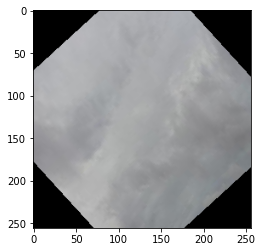

In [2]:
import matplotlib.pyplot as plt
images, labels = next(iter(dataloader_train))
image = images[0].permute(1, 2, 0)
plt.imshow(image)
plt.show()

Let us also transform testing set. We will only apply rotation and resize and not the rest of the transformation we did as in the training dataset

In [3]:

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Resize((128, 128)),
    transforms.Resize((256, 256)),
])


dataset_test = ImageFolder(
  "kaggle/clouds_test",
  transform=test_transforms,
)
dataloader_test = DataLoader(
  dataset_test, shuffle=True, batch_size=16
)

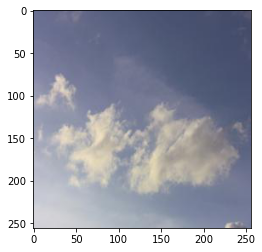

In [4]:
import matplotlib.pyplot as plt
images, labels = next(iter(dataloader_test))
image = images[0].permute(1, 2, 0)
plt.imshow(image)
plt.show()

### Creating classifier model

We will now construct the image classifier model in pytorch. We will create a similar model as we did using tensorflow. However, here we will slightly change the model by adding some new layers.

In [5]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        
        # Feature extractor layers
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ELU(alpha=1.0),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ELU(alpha=1.0),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # New layer
            nn.ELU(alpha=1.0),
            nn.MaxPool2d(kernel_size=2, stride=2),  # New pooling layer
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Another new layer
            nn.ELU(alpha=1.0),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Another new pooling layer
            nn.Flatten()
        )
        
        # Calculate the new in_features for the classifier layer
        self.classifier = nn.Linear(256 * 16 * 16, num_classes)  # Adjust based on the new feature map size

    def forward(self, x):
        # Forward pass through the network
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

# Instantiate the network with num_classes=7
net = Net(num_classes=7)


Let us visualize the model structure with dummy forward pass.

Net(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ELU(alpha=1.0)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ELU(alpha=1.0)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ELU(alpha=1.0)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Linear(in_features=65536, out_features=7, bias=True)
)


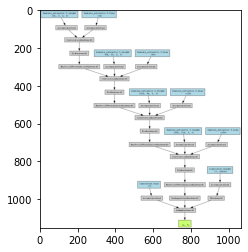

In [11]:
from torchviz import make_dot


# Print the network architecture
print(net)

# Dummy input to create a sample forward pass
x = torch.randn(1, 3, 256, 256)
y = net(x)

model_name = "model_graph"
# Create and save the graph
graph = make_dot(y, params=dict(net.named_parameters()))
graph.render(model_name, format="png")
data = plt.imread(model_name+".png")
plt.imshow(data)
plt.show()